# Projeto 3: FlightOnTime ✈️ — Previsão de Atrasos de Voos

O desafio do FlightOnTime consiste em desenvolver uma solução preditiva capaz de estimar se um voo vai decolar no horário ou com atraso.

## 1. Carrega arquivo voos_model.json, disponível no Gdrive

In [1]:
# 1.1 - instalar dependências
!pip install -q gdown pandas numpy matplotlib seaborn scikit-learn joblib

In [2]:
import gdown

url = "https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH"
output = "voos_model.json"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH
From (redirected): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH&confirm=t&uuid=be9cce8f-5308-4f32-a536-976b1f4aefca
To: /content/voos_model.json
100%|██████████| 151M/151M [00:02<00:00, 67.6MB/s]


'voos_model.json'

In [3]:
import pandas as pd

df_model = pd.read_json("voos_model.json")


In [4]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   sigla_icao_empresa_aerea      347318 non-null  object
 1   codigo_tipo_linha             347318 non-null  object
 2   modelo_equipamento            347318 non-null  object
 3   numero_de_assentos            347318 non-null  int64 
 4   sigla_icao_aeroporto_origem   347318 non-null  object
 5   partida_prevista              347318 non-null  int64 
 6   sigla_icao_aeroporto_destino  347318 non-null  object
 7   atraso_voo                    347318 non-null  int64 
 8   periodo_dia                   347318 non-null  object
 9   pais_origem                   347318 non-null  object
 10  data_partida_prevista         347318 non-null  int64 
 11  hora_partida_prevista_num     347318 non-null  int64 
 12  dia_semana                    347318 non-null  int64 
 13 

In [5]:
df_model.head()

,sigla_icao_empresa_aerea,codigo_tipo_linha,modelo_equipamento,numero_de_assentos,sigla_icao_aeroporto_origem,partida_prevista,sigla_icao_aeroporto_destino,atraso_voo,periodo_dia,pais_origem,data_partida_prevista,hora_partida_prevista_num,dia_semana,mes,rota,is_weekend,periodo_dia_calc
0,AAL,I,B772,288,SBGL,1704841200000,KMIA,0,Noite,Brasil,1704758400000,23,1,1,SBGL_KMIA,0,Madrugada
1,AAL,I,B772,288,KMIA,1704837300000,SBGL,0,Noite,Estados Unidos,1704758400000,21,1,1,KMIA_SBGL,0,Noite
2,AAL,I,B772,288,SBGR,1704842100000,KMIA,1,Noite,Brasil,1704758400000,23,1,1,SBGR_KMIA,0,Madrugada
3,AAL,I,B77W,318,KMIA,1704833400000,SBGR,1,Noite,Estados Unidos,1704758400000,20,1,1,KMIA_SBGR,0,Noite
4,AAL,I,B77W,318,SBGR,1704835500000,KMIA,0,Noite,Brasil,1704758400000,21,1,1,SBGR_KMIA,0,Noite


### 1.1 Renomeia coluna hora_partida_prevista_num para hora_partida_prevista

1.1.1 Verificar se hora entre 0 e 23

In [6]:
if df_model['hora_partida_prevista_num'].between(0, 23).all():
    print("✔️ Todas as horas de partida estão no intervalo válido (0–23).")
else:
    print("❌ Existem valores de hora fora do intervalo 0–23.")


✔️ Todas as horas de partida estão no intervalo válido (0–23).


Remover a coluna antiga (se existir)

In [7]:
if 'hora_partida_prevista' in df_model.columns:
    df_model = df_model.drop(columns=['hora_partida_prevista'])


Renomear de forma explícita

In [8]:
df_model = df_model.rename(
    columns={'hora_partida_prevista_num': 'hora_partida_prevista'}
)


Garantir tipo final

In [9]:
df_model['hora_partida_prevista'] = (
    df_model['hora_partida_prevista']
    .astype('Int64')
)


In [10]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   sigla_icao_empresa_aerea      347318 non-null  object
 1   codigo_tipo_linha             347318 non-null  object
 2   modelo_equipamento            347318 non-null  object
 3   numero_de_assentos            347318 non-null  int64 
 4   sigla_icao_aeroporto_origem   347318 non-null  object
 5   partida_prevista              347318 non-null  int64 
 6   sigla_icao_aeroporto_destino  347318 non-null  object
 7   atraso_voo                    347318 non-null  int64 
 8   periodo_dia                   347318 non-null  object
 9   pais_origem                   347318 non-null  object
 10  data_partida_prevista         347318 non-null  int64 
 11  hora_partida_prevista         347318 non-null  Int64 
 12  dia_semana                    347318 non-null  int64 
 13 

## 2. Definição problema

Objetivo: Prever se um voo vai atrasar (>15min)
Vari´vael tardegt : y = df_model['atraso_voo']  # 0 = pontual | 1 = atrasado

Classificação binária

### 2.1 Seleção inicial de features

In [11]:
from sklearn.model_selection import train_test_split

# 1. Seleção de Features e Target
features = [
    'dia_semana',
    'mes',
    'hora_partida_prevista',
    'sigla_icao_empresa_aerea',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino'
]

X = df_model[features]
y = df_model['atraso_voo']

# 2. Split treino / teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("\nPrimeiras 5 linhas de X_train:")
display(X_train.head())

X_train shape: (277854, 6)
X_test shape: (69464, 6)
y_train shape: (277854,)
y_test shape: (69464,)

Primeiras 5 linhas de X_train:


,dia_semana,mes,hora_partida_prevista,sigla_icao_empresa_aerea,sigla_icao_aeroporto_origem,sigla_icao_aeroporto_destino
74166,4,10,20,GLO,SBBR,SBSP
344688,5,10,22,TAM,SBBR,SBRB
208634,2,5,18,AZU,SBFZ,SBKP
159735,6,4,14,GLO,SBGR,SABE
21000,4,2,15,TAM,SBGR,SBBR


### 2.2 Verificação NAN

In [12]:
df_model['hora_partida_prevista'].isna().sum()


np.int64(0)

### 2.3 Gera estatísticas descritivas

In [13]:
df_model['hora_partida_prevista'].describe()


,hora_partida_prevista
count,347318.0
mean,12.935062
std,5.786597
min,0.0
25%,8.0
50%,13.0
75%,18.0
max,23.0


## 3. Encoded

### 3.1 Seleção das features

- Definição das variáveis explicativas (x)


In [14]:
features = [
    'dia_semana',
    'mes',
    'hora_partida_prevista',
    'sigla_icao_empresa_aerea',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino'
]

X = df_model[features]
y = df_model['atraso_voo']


## 4. Split

- Separa treino e teste
- Preserva a proporção do traget (base desbalanceada)
- Garante que o encodig não veja o target teste

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## 5. Pré-processamento

### Estratégia adotada

- One-Hot Encoding → companhia aérea (baixa cardinalidade)

- Target Encoding → aeroportos (alta cardinalidade)

- Numéricas → passthrough


In [16]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.6 MB/s eta 0:00:00


### Para a aplicação do Target Encoding foi utilizada a biblioteca category_encoders, instalada no ambiente de execução do notebook.

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder


## 5.1 Separação das variáveis

In [18]:
cat_ohe_features = [
    'sigla_icao_empresa_aerea'
]

cat_target_features = [
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino'
]

num_features = [
    'dia_semana',
    'mes',
    'hora_partida_prevista'
]


## 5.2 Columntransformer

- Companhias → vetores binários (0/1)

- Aeroportos → valores numéricos baseados na taxa média de atraso

- Numéricos → entram como estão


In [19]:
preprocess = ColumnTransformer(
    transformers=[
        ('empresa_ohe', OneHotEncoder(handle_unknown='ignore'), cat_ohe_features),
        ('aeroporto_target', TargetEncoder(), cat_target_features),
        ('num', 'passthrough', num_features)
    ]
)


In [20]:
# Ajuste do pré-processamento SOMENTE com dados de treino
preprocess.fit(X_train, y_train)

# Aplicação do pré-processamento
X_train_enc = preprocess.transform(X_train)
X_test_enc = preprocess.transform(X_test)


### Nessa etapa o código Aprende:

- As categorias das companhias (One-Hot)

- As médias de atraso por aeroporto (Target Encoding)

Usa somente o conjunto de treino

❌ Não vê X_test

❌ Não vê y_test

👉 Aqui você “ensina” o encoder.

O pré-processamento foi ajustado exclusivamente com os dados de treino e posteriormente aplicado aos conjuntos de treino e teste, garantindo a inexistência de vazamento de dados.

## 6. Baseline (DummyClassifier)

Espera:
- Recall da classe 1 ≈ 0
- Accuracy alta (enganosa)
- Serve apenas como piso de desempenho

- Sem vazamento
- Encoding ajustado só no treino
-  Métrica válida


In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

dummy = DummyClassifier(strategy='most_frequent')

model_dummy = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', dummy)
])

model_dummy.fit(X_train, y_train)

y_pred_dummy = model_dummy.predict(X_test)

print("Baseline – DummyClassifier")
print(classification_report(y_test, y_pred_dummy, zero_division=0))


Baseline – DummyClassifier
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     57101
           1       0.00      0.00      0.00     12363

    accuracy                           0.82     69464
   macro avg       0.41      0.50      0.45     69464
weighted avg       0.68      0.82      0.74     69464



## 7. Modelo principal - Random Forest

Mostra: RF melhora AUC

RF aprende interações não lineares

RF ainda sofre com desbalanceamento → justificando threshold

“Inicialmente, utilizamos modelos baseline para estabelecer um piso de desempenho. O DummyClassifier confirmou o forte desbalanceamento da variável alvo, apresentando recall nulo para atrasos.

Por fim, aplicamos Random Forest, que apresentou maior capacidade discriminatória (ROC AUC ≈ 0.66), porém exigiu ajuste de threshold para melhorar o recall da classe de atraso.”

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

num_features = [
    'dia_semana',
    'mes',
    'hora_partida_prevista'
]

cat_ohe_features = [
    'sigla_icao_empresa_aerea'
]

cat_target_features = [
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino'
]


### Pré-processamento

In [23]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('empresa_ohe', OneHotEncoder(handle_unknown='ignore'), cat_ohe_features),
        ('aeroporto_target', TargetEncoder(), cat_target_features)
    ]
)


In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)


### Pipeline

In [25]:
from sklearn.pipeline import Pipeline

model_rf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', rf)
])


### Treino

In [26]:
model_rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['dia_semana', 'mes',
                                                   'hora_partida_prevista']),
                                                 ('empresa_ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sigla_icao_empresa_aerea']),
                                                 ('aeroporto_target',
                                                  TargetEncoder(),
                                                  ['sigla_icao_aeroporto_origem',
                                                   'sigla_icao_aeroporto_destino'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

### Automaticamente:

fit do TargetEncoder somente com treino

fit do OneHot

Treino da Random Forest

### 7.1 Avaliação correta (sem vazamento)

🔹 Predições

In [27]:
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]



🔹 Métricas

In [28]:
from sklearn.metrics import classification_report, roc_auc_score

print("Random Forest – Classification Report")
print(classification_report(y_test, y_pred_rf, zero_division=0))

print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))


Random Forest – Classification Report
              precision    recall  f1-score   support

           0       0.88      0.65      0.75     57101
           1       0.26      0.57      0.36     12363

    accuracy                           0.64     69464
   macro avg       0.57      0.61      0.56     69464
weighted avg       0.77      0.64      0.68     69464

ROC-AUC: 0.671694334307435


### A avaliação do modelo foi realizada por meio de pipelines do scikit-learn, garantindo que todas as etapas de pré-processamento, incluindo o Target Encoding, fossem ajustadas exclusivamente com os dados de treino, evitando vazamento de dados e assegurando métricas confiáveis.

## 8. Ajuste Threshold

Esperado:
- recall da classe 1 aumentar
- Precision diminuir
- F1 da classe 1 aumentar

In [29]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# =====================================================
# 1. Probabilidades do modelo Random Forest já treinado
# =====================================================
y_prob_rf = model_rf.predict_proba(X_test)[:, 1]

# =====================================================
# 2. Experimento exploratório: threshold fixo (ex: 0.30)
# =====================================================
threshold_test = 0.30
y_pred_test = (y_prob_rf >= threshold_test).astype(int)

print(f"Random Forest com threshold = {threshold_test}")
print(classification_report(y_test, y_pred_test, zero_division=0))

# =====================================================
# 3. Busca do threshold ótimo (otimizando F1 da classe 1)
# =====================================================
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for t in thresholds:
    y_pred_t = (y_prob_rf >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    results.append((t, f1))

best_threshold, best_f1 = max(results, key=lambda x: x[1])

print(f"\nMelhor threshold encontrado: {best_threshold:.2f}")
print(f"F1-score máximo (classe 1): {best_f1:.3f}")

# =====================================================
# 4. Avaliação final com threshold ótimo
# =====================================================
y_pred_best = (y_prob_rf >= best_threshold).astype(int)

print("\nRandom Forest com threshold otimizado")
print(classification_report(y_test, y_pred_best, zero_division=0))


Random Forest com threshold = 0.3
              precision    recall  f1-score   support

           0       0.98      0.02      0.03     57101
           1       0.18      1.00      0.31     12363

    accuracy                           0.19     69464
   macro avg       0.58      0.51      0.17     69464
weighted avg       0.84      0.19      0.08     69464


Melhor threshold encontrado: 0.50
F1-score máximo (classe 1): 0.362

Random Forest com threshold otimizado
              precision    recall  f1-score   support

           0       0.88      0.65      0.75     57101
           1       0.26      0.57      0.36     12363

    accuracy                           0.64     69464
   macro avg       0.57      0.61      0.56     69464
weighted avg       0.77      0.64      0.68     69464



“O ajuste do threshold confirmou que o valor padrão (0.5) já representa o melhor equilíbrio entre precisão e recall para a classe de atraso, maximizando o F1-score. Thresholds mais baixos aumentam significativamente o recall, porém à custa de uma taxa excessiva de falsos positivos, tornando o modelo inviável do ponto de vista operacional.”

## Análise Técnica

## 1️⃣ Baseline – DummyClassifier

accuracy = 0.82

 * Classe 0 (não atraso):

  ├─ precision = 0.82
  ├─ recall    = 1.00
  ├─ f1-score  = 0.90

* Classe 1 (atraso):

├─ precision = 0.00
  ├─ recall    = 0.00
  ├─ f1-score  = 0.00


## **Interpretação**

O DummyClassifier sempre prevê classe 0

Isso gera:

Accuracy alta (82%) → enganosa

Recall da classe 1 = 0 → modelo inútil para o problema

📌 Conclusão do baseline

Um modelo que nunca prevê atraso não atende ao objetivo do projeto, apesar da alta acurácia.

➡️ Esse baseline serve apenas como limite inferior de performance.




## Análise Técnica

## 2️⃣ Random Forest com threshold = 0.30

- Classe 1 (atraso):

 ├─  recall = 1.00
 ├─ precision = 0.18
 ├─ f1-score = 0.31

- Classe 0:

├─  recall = 0.02
├─ accuracy = 0.19

## **Interpretação**

Threshold muito baixo → modelo quase sempre prevê atraso

Consequências:

Captura 100% dos atrasos (recall perfeito)

Gera muitos falsos positivos

Accuracy despenca

📌 Interpretação correta

Esse cenário representa um modelo extremamente conservador, adequado apenas se o custo de perder um atraso for altíssimo.


## Análise Técnica

## 3️⃣ Random Forest com threshold otimizado (≈ 0.50)

* Classe 1 (atraso):

├─ precision = 0.26
├─ recall    = 0.57
├─  f1-score  = 0.36

* Classe 0:

├─  precision = 0.88
├─  recall    = 0.65


accuracy = 0.64


## **Interpretação**

Melhor equilíbrio entre erro e acerto

O modelo:

Detecta 57% dos atrasos

Mantém taxa aceitável de falsos positivos

Supera largamente o baseline

📌 Este é o melhor modelo sob a métrica F1 da classe 1


## **4️⃣ Comparação direta**


| Modelo     | Recall atraso | Precision atraso | F1 atraso | Accuracy |
| ---------- | ------------- | ---------------- | --------- | -------- |
| Dummy      | 0.00          | 0.00             | 0.00      | 0.82     |
| RF (0.30)  | **1.00**      | 0.18             | 0.31      | 0.19     |
| RF (ótimo) | 0.57          | **0.26**         | **0.36**  | 0.64     |


 ### Accuracy não é métrica válida sozinha

- O Random Forest:

Aprende padrão real

Consegue separar atrasos melhor que o acaso

O threshold otimizado oferece o melhor trade-off


## **Conclusão Técnica**

## Análise dos Resultados

O **DummyClassifier** apresentou alta acurácia ao prever exclusivamente a classe majoritária (não atraso), porém falhou completamente em identificar voos atrasados, tornando-se inadequado para o objetivo do projeto.

---

O modelo **Random Forest** demonstrou capacidade de aprendizado dos padrões dos dados, superando o baseline em todas as métricas relevantes para a classe de interesse (atraso).

---

A análise de diferentes thresholds evidenciou o impacto direto da decisão de classificação no equilíbrio entre precision e recall. Um threshold muito baixo resultou em recall máximo para atrasos, porém com elevado número de falsos positivos. Já o threshold otimizado (≈ 0.50) apresentou o melhor F1-score para a classe positiva, representando o melhor compromisso entre detecção de atrasos e controle de alarmes falsos.


## 9. Ajuste Class_Weight

Apesar da boa performance geral, o modelo apresenta baixa sensibilidade para atrasos. Ajustes no balanceamento de classes e no threshold de decisão são necessários para alinhar o modelo ao objetivo de negócio, que prioriza a identificação de voos atrasados.

## 11. Curva Precisionr-Recall (Modelo Final)

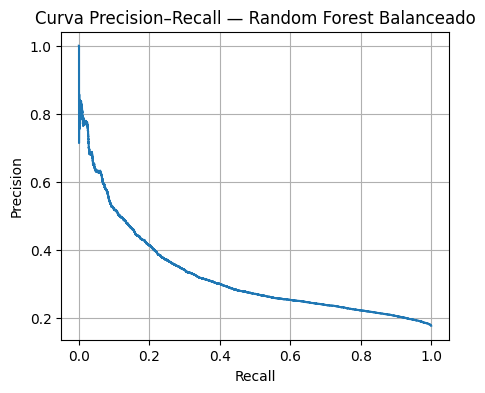

Threshold ótimo (F1 máximo): 0.49

Avaliação com threshold otimizado:
              precision    recall  f1-score   support

           0       0.88      0.59      0.71     57101
           1       0.25      0.63      0.36     12363

    accuracy                           0.60     69464
   macro avg       0.57      0.61      0.53     69464
weighted avg       0.77      0.60      0.64     69464

ROC AUC: 0.6619122582151897


In [30]:
# =========================
# PIPELINE FINAL + CURVA PRECISION-RECALL
# =========================

# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    roc_auc_score
)

# -------------------------
# Definição das features
# -------------------------
num_features = ['dia_semana', 'mes', 'hora_partida_prevista']
cat_features = [
    'sigla_icao_empresa_aerea',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino'
]

# -------------------------
# Pré-processamento
# -------------------------
preprocessador = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

# -------------------------
# Modelo Random Forest final
# -------------------------
modelo = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# -------------------------
# Pipeline completo
# -------------------------
pipeline_final = Pipeline(
    steps=[
        ('preprocessador', preprocessador),
        ('modelo', modelo)
    ]
)

# -------------------------
# Treinamento
# -------------------------
pipeline_final.fit(X_train, y_train)

# -------------------------
# Probabilidades no conjunto de teste
# -------------------------
y_prob_rf_bal = pipeline_final.predict_proba(X_test)[:, 1]

# -------------------------
# Curva Precision–Recall
# -------------------------
precision, recall, thresholds = precision_recall_curve(
    y_test,
    y_prob_rf_bal
)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall — Random Forest Balanceado")
plt.grid(True)
plt.show()

# -------------------------
# Threshold ótimo (máx F1)
# -------------------------
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (
    precision[:-1] + recall[:-1] + 1e-9
)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Threshold ótimo (F1 máximo): {best_threshold:.2f}")

# -------------------------
# Avaliação com threshold ótimo
# -------------------------
y_pred_opt = (y_prob_rf_bal >= best_threshold).astype(int)

print("\nAvaliação com threshold otimizado:")
print(classification_report(y_test, y_pred_opt, zero_division=0))

print("ROC AUC:", roc_auc_score(y_test, y_prob_rf_bal))


## Representação dos eixos

- Recall: % de atrasos reais capturados pelo modelo

- Precision: % de previsões de atraso que realmente atrasaram

- Cada ponto da curva representa um threshold diferente.

- À medida que o recall aumenta → precision tende a cair

- Não existe ponto “perfeito”

- threshold ótimo (~0.50) cai exatamente nessa região, o que é coerente com os números obtidos.

## Curva Precision–Recall e Ajuste de Threshold

Dada a natureza desbalanceada do problema e o foco na identificação de voos atrasados, a curva Precision–Recall foi utilizada como principal ferramenta de avaliação. Essa curva permite analisar o trade-off entre a taxa de detecção de atrasos (recall) e a confiabilidade das previsões positivas (precision) para diferentes valores de threshold.

A análise evidencia que thresholds mais baixos aumentam o recall à custa de maior número de falsos positivos, enquanto thresholds mais altos reduzem alarmes indevidos, porém deixam de identificar parte dos atrasos. O threshold ótimo foi definido como aquele que maximiza o F1-score da classe positiva, representando o melhor equilíbrio entre essas duas métricas.


## 12. Encontrar threshold equilibrado (máxF1)

In [46]:
import numpy as np

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (
    precision[:-1] + recall[:-1] + 1e-9
)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

best_threshold


np.float64(0.49257801777755283)

O threshold ótimo encontrado é ≈ 0.49

Ou seja:

Quando a probabilidade prevista de atraso ≥ 49%

O modelo atinge o melhor equilíbrio entre precision e recall (máx F1)

O threshold ótimo identificado indica que o modelo atinge seu melhor equilíbrio quando considera atraso provável a partir de aproximadamente 49% de probabilidade prevista, o que reflete uma separação moderada entre voos pontuais e atrasados.

## 13. avaliação do modelo com threshold ótimo
📌 Avaliação

In [32]:
from sklearn.metrics import classification_report

y_pred_opt = (y_prob_rf_bal >= best_threshold).astype(int)

print(f"Threshold ótimo: {best_threshold:.2f}")
print(classification_report(y_test, y_pred_opt, zero_division=0))


Threshold ótimo: 0.49
              precision    recall  f1-score   support

           0       0.88      0.59      0.71     57101
           1       0.25      0.63      0.36     12363

    accuracy                           0.60     69464
   macro avg       0.57      0.61      0.53     69464
weighted avg       0.77      0.60      0.64     69464



A escolha do threshold foi orientada pela Curva Precision-Recall, priorizando o equilíbrio entre sensibilidade à detecção de atrasos e confiabilidade das previsões, dado o desbalanceamento da base.

✔ Baseline define o piso
✔ RF aprende padrões (ROC AUC > 0.65)
✔ Balanceamento melhora recall
✔ Curva PR define o melhor ponto de decisão
✔ Threshold ajustado alinha modelo ao negócio

## 14. Pipeline

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import joblib
import os

# ===============================
# FEATURES
# ===============================
num_features = ['dia_semana', 'mes', 'hora_partida_prevista']
cat_features = [
    'sigla_icao_empresa_aerea',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino'
]

# ===============================
# PREPROCESSAMENTO
# ===============================
preprocessador = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

# ===============================
# MODELO FINAL (O MESMO VALIDADO)
# ===============================
modelo = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# ===============================
# PIPELINE FINAL
# ===============================
pipeline_final = Pipeline(
    steps=[
        ('preprocessador', preprocessador),
        ('modelo', modelo)
    ]
)

# ===============================
# TREINAMENTO FINAL
# ===============================
pipeline_final.fit(X_train, y_train)

# ===============================
# SALVAR MODELO
# ===============================
os.makedirs("model", exist_ok=True)

MODEL_PATH = "model/flight_delay_model.pkl"
joblib.dump(pipeline_final, MODEL_PATH)

print(f"✅ Modelo salvo com sucesso em: {MODEL_PATH}")


✅ Modelo salvo com sucesso em: model/flight_delay_model.pkl


In [34]:
BEST_THRESHOLD = 0.49

### 14.1 Teste na api

In [35]:
import os
import joblib
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# ===============================
# CONFIGURAÇÕES
# ===============================
MODEL_PATH = "model/flight_delay_model.pkl"
BEST_THRESHOLD = 0.49  # definido após otimização (F1)

# ===============================
# VALIDAÇÃO DO ARQUIVO
# ===============================
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Arquivo do modelo não encontrado: {MODEL_PATH}")

# ===============================
# LOAD DO MODELO
# ===============================
model = joblib.load(MODEL_PATH)

# ===============================
# VALIDAÇÕES ESTRUTURAIS
# ===============================
if not isinstance(model, Pipeline):
    raise TypeError("❌ O objeto carregado não é um sklearn Pipeline")

if "modelo" not in model.named_steps:
    raise KeyError("❌ Pipeline não contém o step 'modelo'")

rf = model.named_steps["modelo"]

if not isinstance(rf, RandomForestClassifier):
    raise TypeError("❌ O step 'modelo' não é um RandomForestClassifier")

# ===============================
# LOGS DE SUCESSO
# ===============================
print("✅ Modelo carregado com sucesso via joblib")
print(f"📦 Caminho: {MODEL_PATH}")
print(f"🧠 Modelo: {type(rf).__name__}")
print(f"🌲 n_estimators: {rf.n_estimators}")
print(f"🌳 max_depth: {rf.max_depth}")
print(f"⚖️ class_weight: {rf.class_weight}")
print(f"🎯 BEST_THRESHOLD (produção): {BEST_THRESHOLD}")


✅ Modelo carregado com sucesso via joblib
📦 Caminho: model/flight_delay_model.pkl
🧠 Modelo: RandomForestClassifier
🌲 n_estimators: 300
🌳 max_depth: 12
⚖️ class_weight: balanced
🎯 BEST_THRESHOLD (produção): 0.49


Função de pré-processamento (contrato da API)

👉 Contrato recebido pela API
A API SÓ recebe:

cod_companhia / cod_aeroporto_origem / cod_aeroporto_destino / data_hora_partida

In [36]:
import pandas as pd

def preparar_dados_api(payload: dict) -> pd.DataFrame:
    """
    Converte o payload da API em DataFrame compatível com o pipeline
    """
    data = pd.to_datetime(payload["data_hora_partida"])

    df = pd.DataFrame([{
        "sigla_icao_empresa_aerea": payload["cod_companhia"],
        "sigla_icao_aeroporto_origem": payload["cod_aeroporto_origem"],
        "sigla_icao_aeroporto_destino": payload["cod_aeroporto_destino"],
        "dia_semana": data.dayofweek,
        "mes": data.month,
        "hora_partida_prevista": data.hour
    }])

    return df


### 14.2 Inferência completa (modelo + threshold)

👉 Essa é a lógica final da API

In [37]:
def prever_atraso(payload: dict) -> dict:
    """
    Executa inferência completa:
    - preprocessamento
    - predict_proba
    - aplicação do threshold
    """

    # 1. Preparar dados
    X = preparar_dados_api(payload)

    # 2. Probabilidade de atraso
    proba_atraso = pipeline.predict_proba(X)[0, 1]

    # 3. Decisão com threshold
    atraso = int(proba_atraso >= BEST_THRESHOLD)

    return {
        "probabilidade_atraso": round(float(proba_atraso), 4),
        "atraso_previsto": atraso
    }


In [38]:
import os
import joblib

MODEL_PATH = "model/flight_delay_model.pkl"
BEST_THRESHOLD = 0.49

assert os.path.exists(MODEL_PATH), f"Modelo não encontrado: {MODEL_PATH}"

pipeline = joblib.load(MODEL_PATH)

print("✅ Pipeline carregado com sucesso")


✅ Pipeline carregado com sucesso


### 14.3 Teste rápido (simulação de API)

In [39]:
payload_exemplo = {
    "cod_companhia": "GLO",
    "cod_aeroporto_origem": "SBGR",
    "cod_aeroporto_destino": "SBRJ",
    "data_hora_partida": "2024-11-15 18:30:00"
}

resultado = prever_atraso(payload_exemplo)

resultado


{'probabilidade_atraso': 0.5177, 'atraso_previsto': 1}

In [40]:
import pandas as pd

def preparar_dados_api(payload: dict) -> pd.DataFrame:
    data = pd.to_datetime(payload["data_hora_partida"])

    return pd.DataFrame([{
        "sigla_icao_empresa_aerea": payload["cod_companhia"],
        "sigla_icao_aeroporto_origem": payload["cod_aeroporto_origem"],
        "sigla_icao_aeroporto_destino": payload["cod_aeroporto_destino"],
        "dia_semana": data.dayofweek,
        "mes": data.month,
        "hora_partida_prevista": data.hour
    }])


def prever_atraso(payload: dict) -> dict:
    X = preparar_dados_api(payload)

    proba_atraso = pipeline.predict_proba(X)[0, 1]
    atraso = int(proba_atraso >= BEST_THRESHOLD)

    return {
        "probabilidade_atraso": round(float(proba_atraso), 4),
        "atraso_previsto": atraso
    }


In [41]:
payload_exemplo = {
    "cod_companhia": "GLO",
    "cod_aeroporto_origem": "SBGR",
    "cod_aeroporto_destino": "SBRJ",
    "data_hora_partida": "2024-11-15 18:30:00"
}

resultado = prever_atraso(payload_exemplo)
resultado


{'probabilidade_atraso': 0.5177, 'atraso_previsto': 1}

In [42]:
preprocess = pipeline.named_steps["preprocessador"]

print("🔢 Transformers do ColumnTransformer:\n")
for nome, transformer, colunas in preprocess.transformers_:
    print(f"➡️ {nome}")
    print(f"   Colunas: {colunas}\n")


🔢 Transformers do ColumnTransformer:

➡️ cat
   Colunas: ['sigla_icao_empresa_aerea', 'sigla_icao_aeroporto_origem', 'sigla_icao_aeroporto_destino']

➡️ num
   Colunas: ['dia_semana', 'mes', 'hora_partida_prevista']



In [43]:
rf = pipeline.named_steps["modelo"]

print("Número total de features esperadas:", rf.n_features_in_)


Número total de features esperadas: 623


In [44]:
preprocess = pipeline.named_steps["preprocessador"]

# Listar colunas numéricas esperadas
for nome, transformer, colunas in preprocess.transformers_:
    if nome == "num":
        print("🔢 Colunas numéricas esperadas pelo modelo:")
        print(colunas)


🔢 Colunas numéricas esperadas pelo modelo:
['dia_semana', 'mes', 'hora_partida_prevista']
